In this notebook, I will build a tariff plan using the random forest refressor. I will organize the notebook like this:
- Fit in a random forest for frequency.
- Fit in a random forest for severity.
- Explain the results for frequency and severity separately.

Importing required packages for the analysis.

In [116]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.tree import plot_tree
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
import joblib  # save and load GridSearchCV objects

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import os
from datetime import datetime

Relative imports are confusing, and I only have three python functions anyway.

In [121]:
def postcodes_to_latlong(df: pd.DataFrame):
    spatial = pd.read_excel("../initial_docs/inspost.xls")
    spatial.drop(columns=["INS", "COMMUNE"], inplace=True)  # we do not need these info
    tmp_df = pd.merge(df, spatial, how="left", on="CODPOSS")
    tmp_df.drop(columns="CODPOSS", inplace=True)
    
    return tmp_df


def cat_to_numeric(data: pd.DataFrame):
    tmp = data.copy(deep=True)
    
    tmp['agecar'] = tmp['agecar'].map({"0-1": 0, "2-5": 1, "6-10":2, ">10": 3})
    tmp['sexp'] = tmp['sexp'].map({"Male": 0, "Female": 1})
    tmp['fuelc'] = tmp['fuelc'].map({"Petrol": 0, "Gasoil": 1})
    tmp['split'] = tmp['split'].map({"Once": 0, "Monthly": 1, "Twice":2, "Thrice": 3})
    tmp['usec'] = tmp['usec'].map({"Private": 0, "Professional": 1})
    tmp['fleetc'] = tmp['fleetc'].map({"Yes": 0, "No": 1})
    tmp['sportc'] = tmp['sportc'].map({"Yes": 0, "No": 1})
    tmp['coverp'] = tmp['coverp'].map({"MTPL": 0, "MTPL+": 1, "MTPL+++":2})
    tmp['powerc'] = tmp['powerc'].map({"<66": 0, "66-110": 1, ">110":2})
    
    return tmp


def avg_claim(row):
    if row['nbrtotc'] == 0:
        return 0
    else:
        return row['chargtot'] / row['nbrtotc']

Read the data.

In [5]:
data = pd.read_csv("../data/train.csv", index_col="Unnamed: 0")
data.head()

,AGEPH,CODPOSS,duree,lnexpo,nbrtotc,nbrtotan,chargtot,agecar,sexp,fuelc,split,usec,fleetc,sportc,coverp,powerc
11349,53,7500,1.000000,0.000000,0,0.00,0.000000,6-10,Female,Petrol,Once,Private,No,No,MTPL+,66-110
94835,42,3090,0.684932,-0.378436,1,1.46,65.691784,2-5,Male,Petrol,Monthly,Private,No,No,MTPL,<66
71207,63,3800,1.000000,0.000000,0,0.00,0.000000,2-5,Male,Gasoil,Once,Private,No,No,MTPL,<66
76198,38,4360,0.698630,-0.358634,0,0.00,0.000000,2-5,Male,Petrol,Once,Private,No,No,MTPL+,66-110
20614,26,7130,1.000000,0.000000,0,0.00,0.000000,2-5,Female,Petrol,Once,Private,No,No,MTPL,<66


Post-codes are purely categorical (not ordinal) with a lot of levels, one-hot encoding or even embedding into $\mathbb{N}$ makes little sense. However, I don't want to throw away the spatial info, since it may play an effect. Instead of working with CODPOSS, I will instead work with latitudes and longitudes.

In [29]:
data2 = postcodes_to_latlong(data)
data2.head()

,AGEPH,duree,lnexpo,nbrtotc,nbrtotan,chargtot,agecar,sexp,fuelc,split,usec,fleetc,sportc,coverp,powerc,LAT,LONG
0,53,1.000000,0.000000,0,0.00,0.000000,6-10,Female,Petrol,Once,Private,No,No,MTPL+,66-110,50.600000,3.383333
1,42,0.684932,-0.378436,1,1.46,65.691784,2-5,Male,Petrol,Monthly,Private,No,No,MTPL,<66,50.766667,4.533333
2,63,1.000000,0.000000,0,0.00,0.000000,2-5,Male,Gasoil,Once,Private,No,No,MTPL,<66,50.800000,5.183333
3,38,0.698630,-0.358634,0,0.00,0.000000,2-5,Male,Petrol,Once,Private,No,No,MTPL+,66-110,50.716667,5.350000
4,26,1.000000,0.000000,0,0.00,0.000000,2-5,Female,Petrol,Once,Private,No,No,MTPL,<66,50.400000,4.150000


We will need to convert the categoricals here into numeric, since SKLearn only works with numerics. *agecar, split, coverp*, and *powerc* have more than two levels, but fortunately they are ordinals, so it splitting on <2 makes more sense (compared to when you have pure categorical, splitting on <2 is very arbitrary).

In [30]:
categoricals = data2.select_dtypes(include=np.object_).columns
for category in categoricals:
    print(category + ":", data2[category].unique())

agecar: ['6-10' '2-5' '>10' '0-1']
sexp: ['Female' 'Male']
fuelc: ['Petrol' 'Gasoil']
split: ['Once' 'Monthly' 'Twice' 'Thrice']
usec: ['Private' 'Professional']
fleetc: ['No' 'Yes']
sportc: ['No' 'Yes']
coverp: ['MTPL+' 'MTPL' 'MTPL+++']
powerc: ['66-110' '<66' '>110']


In [32]:
data2 = cat_to_numeric(data2)
for category in categoricals:
    print(category + ":", data2[category].unique())

agecar: [2 1 3 0]
sexp: [1 0]
fuelc: [0 1]
split: [0 1 2 3]
usec: [0 1]
fleetc: [1 0]
sportc: [1 0]
coverp: [1 0 2]
powerc: [1 0 2]


Partitioning the data into features and targets.

In [33]:
features = ["AGEPH", "LAT", "LONG"] + list(categoricals)  # list addition is concatenation

freq_target = data2['nbrtotc']/data2['duree']
freq_weights = data2['duree']
freq_features = data2.loc[:, features]

sev_data2 = data2.query("nbrtotc > 0")

sev_target = sev_data2['chargtot']/sev_data2['nbrtotc']
sev_weights = sev_data2['nbrtotc']
sev_features = sev_data2.loc[:, features]

freq_features.head()

,AGEPH,LAT,LONG,agecar,sexp,fuelc,split,usec,fleetc,sportc,coverp,powerc
0,53,50.600000,3.383333,2,1,0,0,0,1,1,1,1
1,42,50.766667,4.533333,1,0,0,1,0,1,1,0,0
2,63,50.800000,5.183333,1,0,1,0,0,1,1,0,0
3,38,50.716667,5.350000,1,0,0,0,0,1,1,1,1
4,26,50.400000,4.150000,1,1,0,0,0,1,1,0,0


## Fitting in frequency.

In another class, it was highlighted that RandomForests do not require tuning for depth and number of trees, simply the more the merrier. This simplifies the grid search, and I will be able to check out more values for *max_features* and *max_samples*.

Below is an estimate on how long one parameter configuration will take. Five hundred trees takes twelve seconds, I think that is workable. The only hyperparameters I will tune are *max_features* and *max_samples*, and I will partition them on a coarser grid to begin with. After checking the results, I will try a refined grid, with more trees as well.

I think that *min_weight_fraction_leaf* at $1\%$ is reasonable for frequency, as this is more than 1k observations.

In [127]:
_ = RandomForestRegressor(n_estimators=500, criterion="poisson", max_depth=7,
                                min_samples_split=0.05, min_weight_fraction_leaf=0.01, random_state=0,
                                max_features="sqrt", max_samples=0.6)

now = datetime.now()
_.fit(X=freq_features, y=freq_target, sample_weight=freq_weights)

print(f"Time taken = {(datetime.now() - now).seconds} seconds")

Time taken = 12 seconds


Set up the param-grid and base estimator. Assuming 12 seconds run per configuration on a single fold, with 5-fold CV that means a minute fore every point on the grid. I impose a strict budget of 15-minutes, which is reflected on the parameter grid below.

In [145]:
freq_param_grid = {"max_features": [2, 3, 4, 6, 8],
                   "max_samples": [0.3, 0.5, 0.7]}

freq_rf = RandomForestRegressor(n_estimators=500, criterion="poisson", max_depth=7,
                                min_samples_split=0.05, min_weight_fraction_leaf=0.01, random_state=0)

Kick off the search. Also, save the results, since this is a long calculation.

In [149]:
# freq_grid = GridSearchCV(freq_rf, freq_param_grid, scoring="neg_mean_poisson_deviance", cv=5, refit=False, verbose=1)

now = datetime.now()
# freq_grid.fit(X=freq_features, y=freq_target, sample_weight=freq_weights)
print(f"Time taken {(datetime.now() - now).seconds} seconds")

# joblib.dump(freq_grid, "../models/initial_freq_grid.pkl")

# joblib.load("../models/initial_freq_grid.pkl")

Time taken 0 seconds


Plotting the mean deviances, the lower the better. The trend is very straightforward, higher *max_sample* performs better, lower *max_features* performs better. Since number of features each split is only 2, that means we needed uncorrelated trees.

In [231]:
results = freq_grid.cv_results_
results_df = pd.DataFrame({"max_features": results["param_max_features"].data,
                           "max_samples": results["param_max_samples"].data,
                           "rank": results["rank_test_score"],
                           "mean_test_score": -results["mean_test_score"]})  # remove the negative
results_df = results_df.sort_values(["max_samples", "max_features"])

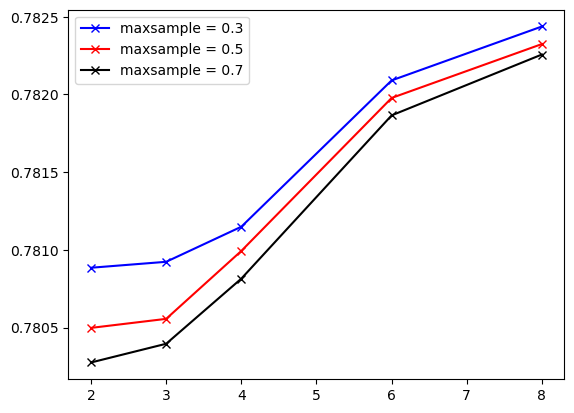

In [338]:
maxsample_pointthree = results_df.query("max_samples==0.3").filter(["max_features", "mean_test_score"])
maxsample_pointfive = results_df.query("max_samples==0.5").filter(["max_features", "mean_test_score"])
maxsample_pointseven = results_df.query("max_samples==0.7").filter(["max_features", "mean_test_score"])

plt.plot(maxsample_pointthree.iloc[:, 0], maxsample_pointthree.iloc[:, 1], "blue", marker="x")
plt.plot(maxsample_pointfive.iloc[:, 0], maxsample_pointfive.iloc[:, 1], "red", marker="x")
plt.plot(maxsample_pointseven.iloc[:, 0], maxsample_pointseven.iloc[:, 1], "black", marker="x")

plt.legend(["maxsample = 0.3", "maxsample = 0.5", "maxsample = 0.7"])
plt.show()

In [222]:
maxsample_pointthree.iloc[:, 0]

0     2
3     3
6     4
9     6
12    8
Name: max_features, dtype: object

Refined grid search, increased number of trees from 500 to 1000 as well.

In [274]:
freq_param_grid_final = freq_param_grid = {"max_features": [1, 2],
                                           "max_samples": [0.65, 0.7, 0.75, 0.8, 0.85]}
freq_rf2 = RandomForestRegressor(n_estimators=1000, criterion="poisson", max_depth=7,
                                min_samples_split=0.05, min_weight_fraction_leaf=0.01, random_state=0)

freq_grid_final = GridSearchCV(freq_rf2, freq_param_grid_final, scoring="neg_mean_poisson_deviance",
                               cv=5, refit=False, verbose=1)

now = datetime.now()
freq_grid_final.fit(X=freq_features, y=freq_target, sample_weight=freq_weights)
print(f"Time taken {(datetime.now() - now).seconds} seconds")

joblib.dump(freq_grid, "../models/final_freq_grid.pkl")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Time taken 703 seconds


['../models/final_freq_grid.pkl']

In [275]:
results2 = freq_grid_final.cv_results_
results2_df = pd.DataFrame({"max_features": results2["param_max_features"].data,
                           "max_samples": results2["param_max_samples"].data,
                           "rank": results2["rank_test_score"],
                           "mean_test_score": -results2["mean_test_score"]})  # remove the negative
results2_df = results2_df.sort_values(["max_samples", "max_features"])

results2_df

,max_features,max_samples,rank,mean_test_score
0,1,0.65,10,0.782251
5,2,0.65,5,0.780345
1,1,0.7,9,0.782217
6,2,0.7,4,0.780307
2,1,0.75,8,0.782191
7,2,0.75,3,0.780259
3,1,0.8,7,0.782174
8,2,0.8,2,0.780225
4,1,0.85,6,0.782156
9,2,0.85,1,0.780171


It is only slightly better.

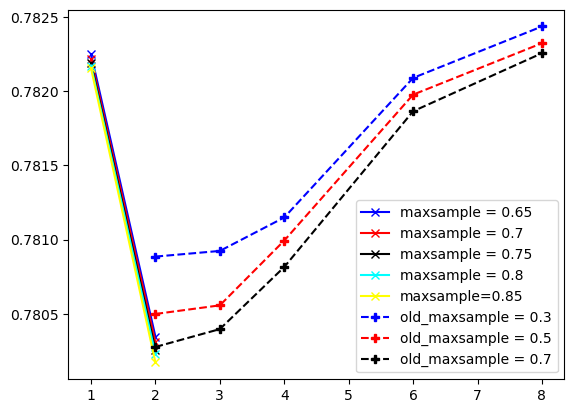

In [340]:
a1 = results2_df.query("max_samples==0.65").filter(["max_features", "mean_test_score"])
a2 = results2_df.query("max_samples==0.7").filter(["max_features", "mean_test_score"])
a3 = results2_df.query("max_samples==0.75").filter(["max_features", "mean_test_score"])
a4 = results2_df.query("max_samples==0.80").filter(["max_features", "mean_test_score"])
a5 = results2_df.query("max_samples==0.85").filter(["max_features", "mean_test_score"])

plt.plot(a1.iloc[:, 0], a1.iloc[:, 1], "blue", marker="x")
plt.plot(a2.iloc[:, 0], a2.iloc[:, 1], "red", marker="x")
plt.plot(a3.iloc[:, 0], a3.iloc[:, 1], "black", marker="x")
plt.plot(a4.iloc[:, 0], a4.iloc[:, 1], "cyan", marker="x")
plt.plot(a5.iloc[:, 0], a5.iloc[:, 1], "yellow", marker="x")

plt.plot(maxsample_pointthree.iloc[:, 0], maxsample_pointthree.iloc[:, 1], "blue", linestyle="dashed", marker="P")
plt.plot(maxsample_pointfive.iloc[:, 0], maxsample_pointfive.iloc[:, 1], "red", linestyle="dashed", marker="P")
plt.plot(maxsample_pointseven.iloc[:, 0], maxsample_pointseven.iloc[:, 1], "black", linestyle="dashed", marker="P")

plt.legend(["maxsample = 0.65", "maxsample = 0.7", "maxsample = 0.75", "maxsample = 0.8", "maxsample=0.85",
            "old_maxsample = 0.3", "old_maxsample = 0.5", "old_maxsample = 0.7"])
plt.show()

Retrain final model with full trainset.

In [279]:
# freq_rf_final = RandomForestRegressor(n_estimators=1000, criterion="poisson", max_depth=7,
                                      min_samples_split=0.05, min_weight_fraction_leaf=0.01, random_state=0,
                                      max_features=2, max_samples=0.85)
# freq_rf_final.fit(X=freq_features, y=freq_target, sample_weight=freq_weights)

RandomForestRegressor(criterion='poisson', max_depth=7, max_features=2,
                      max_samples=0.85, min_samples_split=0.05,
                      min_weight_fraction_leaf=0.01, n_estimators=1000,
                      random_state=0)

Save final frequency model.

In [20]:
# joblib.dump(freq_rf_final, "../models/freq_rf.pkl")
freq_rf_final = joblib.load("../models/freq_rf.pkl")

## Fitting in severity.

Now I will find a severity model. With only 12k observations, I expect computations are much faster so we can use even more trees and put more points on the parameters grid.

An interesting thing we can try is using both *squared_error* and *absolute_error* as criterions. Since we have some insane outliers, using *absolute_error* might prevent each trees from latching on to the extreme outliers.

We only needed 4 seconds, I will be generous with the parameter grid. [UPDATE:] Deciding to be generous and not calculating time taken is a bad mistake, I just realized that it will take 70 mins to finish the calculations.

In [261]:
now = datetime.now()
sev_rf = RandomForestRegressor(n_estimators=1000, criterion="squared_error", max_depth=7,
                               min_samples_split=0.05, min_weight_fraction_leaf=0.01, random_state=0,
                               max_features=5, max_samples=0.8)
sev_rf.fit(X=sev_features, y=sev_target, sample_weight=sev_weights)
print(f"Took {(datetime.now()-now).seconds} seconds")

Took 4 seconds


Creating initial coarse parameter grid.

In [277]:
sev_param_grid = {"criterion": ["squared_error", "absolute_error"],
                  "max_features": [2, 4, 6],
                  "max_samples": [0.7, 0.8, 0.9],
                  "max_depth": [7, 9]}

sev_initial_rf = RandomForestRegressor(n_estimators=1000, min_samples_split=0.05,
                                       min_weight_fraction_leaf=0.01, random_state=0)

Perform the grid search, and save the model.

In [278]:
now = datetime.now()

sev_initial_grid = GridSearchCV(estimator=sev_initial_rf, param_grid=sev_param_grid,
                                scoring="neg_mean_gamma_deviance", refit=False, verbose=2, cv=5)
# sev_initial_grid.fit(X=sev_features, y=sev_target, sample_weight=sev_weights)

print(f"Took {(datetime.now()-now).seconds} seconds")

# joblib.dump(sev_initial_grid, "../models/initial_sev_grid.pkl")

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END criterion=squared_error, max_depth=7, max_features=2, max_samples=0.7; total time=   2.0s
[CV] END criterion=squared_error, max_depth=7, max_features=2, max_samples=0.7; total time=   2.0s
[CV] END criterion=squared_error, max_depth=7, max_features=2, max_samples=0.7; total time=   2.1s
[CV] END criterion=squared_error, max_depth=7, max_features=2, max_samples=0.7; total time=   2.1s
[CV] END criterion=squared_error, max_depth=7, max_features=2, max_samples=0.7; total time=   2.4s
[CV] END criterion=squared_error, max_depth=7, max_features=2, max_samples=0.8; total time=   2.3s
[CV] END criterion=squared_error, max_depth=7, max_features=2, max_samples=0.8; total time=   2.1s
[CV] END criterion=squared_error, max_depth=7, max_features=2, max_samples=0.8; total time=   2.2s
[CV] END criterion=squared_error, max_depth=7, max_features=2, max_samples=0.8; total time=   2.1s
[CV] END criterion=squared_error, max_depth=7, 

[CV] END criterion=squared_error, max_depth=9, max_features=6, max_samples=0.8; total time=   4.5s
[CV] END criterion=squared_error, max_depth=9, max_features=6, max_samples=0.8; total time=   5.2s
[CV] END criterion=squared_error, max_depth=9, max_features=6, max_samples=0.9; total time=   5.2s
[CV] END criterion=squared_error, max_depth=9, max_features=6, max_samples=0.9; total time=   5.3s
[CV] END criterion=squared_error, max_depth=9, max_features=6, max_samples=0.9; total time=   4.9s
[CV] END criterion=squared_error, max_depth=9, max_features=6, max_samples=0.9; total time=   5.8s
[CV] END criterion=squared_error, max_depth=9, max_features=6, max_samples=0.9; total time=   6.4s
[CV] END criterion=absolute_error, max_depth=7, max_features=2, max_samples=0.7; total time= 2.3min
[CV] END criterion=absolute_error, max_depth=7, max_features=2, max_samples=0.7; total time= 2.5min
[CV] END criterion=absolute_error, max_depth=7, max_features=2, max_samples=0.7; total time= 2.5min
[CV] EN

[CV] END criterion=absolute_error, max_depth=9, max_features=6, max_samples=0.7; total time= 5.4min
[CV] END criterion=absolute_error, max_depth=9, max_features=6, max_samples=0.7; total time= 5.5min
[CV] END criterion=absolute_error, max_depth=9, max_features=6, max_samples=0.7; total time= 5.1min
[CV] END criterion=absolute_error, max_depth=9, max_features=6, max_samples=0.7; total time= 5.6min
[CV] END criterion=absolute_error, max_depth=9, max_features=6, max_samples=0.7; total time= 5.3min
[CV] END criterion=absolute_error, max_depth=9, max_features=6, max_samples=0.8; total time= 6.5min
[CV] END criterion=absolute_error, max_depth=9, max_features=6, max_samples=0.8; total time= 6.4min
[CV] END criterion=absolute_error, max_depth=9, max_features=6, max_samples=0.8; total time= 6.0min
[CV] END criterion=absolute_error, max_depth=9, max_features=6, max_samples=0.8; total time= 6.5min
[CV] END criterion=absolute_error, max_depth=9, max_features=6, max_samples=0.8; total time= 6.1min


['../models/initial_sev_grid.pkl']

In [288]:
sev_results = sev_initial_grid.cv_results_
sev_results_df = pd.DataFrame({"max_features": sev_results["param_max_features"].data,
                               "max_samples": sev_results["param_max_samples"].data,
                               "rank": sev_results["rank_test_score"],
                               "mean_test_score": -sev_results["mean_test_score"],
                               "criterion": sev_results["param_criterion"],
                               "max_depth": sev_results["param_max_depth"]})  # remove the negative
sev_results_df = sev_results_df.sort_values(["criterion", "max_depth", "max_samples", "max_features"])

sev_results_df

,max_features,max_samples,rank,mean_test_score,criterion,max_depth
18,2,0.7,20,4.500497,absolute_error,7
21,4,0.7,26,4.626223,absolute_error,7
24,6,0.7,32,4.702201,absolute_error,7
19,2,0.8,19,4.499684,absolute_error,7
22,4,0.8,27,4.640479,absolute_error,7
25,6,0.8,35,4.731635,absolute_error,7
20,2,0.9,21,4.506750,absolute_error,7
23,4,0.9,30,4.655836,absolute_error,7
26,6,0.9,36,4.740943,absolute_error,7
27,2,0.7,22,4.510542,absolute_error,9


Plotting the results.

In [302]:
ae_depthseven_pointseven = sev_results_df.iloc[0:3, [0, 3]]
ae_depthseven_pointeight = sev_results_df.iloc[3:6, [0, 3]]
ae_depthseven_pointnine = sev_results_df.iloc[6:9, [0, 3]]

ae_depthnine_pointseven = sev_results_df.iloc[9:12, [0, 3]]
ae_depthnine_pointeight = sev_results_df.iloc[12:15, [0, 3]]
ae_depthnine_pointnine = sev_results_df.iloc[15:18, [0, 3]]

se_depthseven_pointseven = sev_results_df.iloc[18:21, [0, 3]]
se_depthseven_pointeight = sev_results_df.iloc[21:24, [0, 3]]
se_depthseven_pointnine = sev_results_df.iloc[24:27, [0, 3]]

se_depthnine_pointseven = sev_results_df.iloc[27:30, [0, 3]]
se_depthnine_pointeight = sev_results_df.iloc[30:33, [0, 3]]
se_depthnine_pointnine = sev_results_df.iloc[33:36, [0, 3]]

The conclusion here is that despite taking 7 hours of computation time, checking out mean absolute error was useless. Looks like *max_sample* has more of an effect compared to *max_depth*, but *max_depth* does have an effect. It seems lower *max_depth* with higher *max_sample* is better,

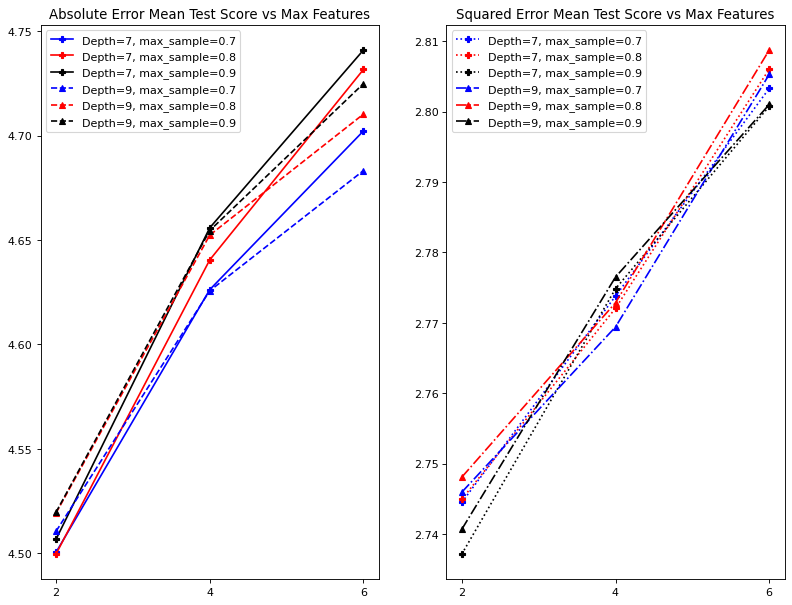

In [343]:
plt.figure(figsize=(12, 9), dpi=80)

plt.subplot(1, 2, 1)

plt.plot(ae_depthseven_pointseven.iloc[:, 0], ae_depthseven_pointseven.iloc[:, 1], "blue", marker="P")
plt.plot(ae_depthseven_pointeight.iloc[:, 0], ae_depthseven_pointeight.iloc[:, 1], "red", marker="P")
plt.plot(ae_depthseven_pointnine.iloc[:, 0], ae_depthseven_pointnine.iloc[:, 1], "black", marker="P")

plt.plot(ae_depthnine_pointseven.iloc[:, 0], ae_depthnine_pointseven.iloc[:, 1], "blue", linestyle="dashed", marker="^")
plt.plot(ae_depthnine_pointeight.iloc[:, 0], ae_depthnine_pointeight.iloc[:, 1], "red", linestyle="dashed", marker="^")
plt.plot(ae_depthnine_pointnine.iloc[:, 0], ae_depthnine_pointnine.iloc[:, 1], "black", linestyle="dashed", marker="^")

plt.legend(["Depth=7, max_sample=0.7", "Depth=7, max_sample=0.8", "Depth=7, max_sample=0.9",
            "Depth=9, max_sample=0.7", "Depth=9, max_sample=0.8", "Depth=9, max_sample=0.9"])
plt.xticks([2, 4, 6])
plt.title("Absolute Error Mean Test Score vs Max Features")

plt.subplot(1, 2, 2)

plt.plot(se_depthseven_pointseven.iloc[:, 0], se_depthseven_pointseven.iloc[:, 1], "blue", linestyle="dotted", marker="P")
plt.plot(se_depthseven_pointeight.iloc[:, 0], se_depthseven_pointeight.iloc[:, 1], "red", linestyle="dotted", marker="P")
plt.plot(se_depthseven_pointnine.iloc[:, 0], se_depthseven_pointnine.iloc[:, 1], "black", linestyle="dotted", marker="P")

plt.plot(se_depthnine_pointseven.iloc[:, 0], se_depthnine_pointseven.iloc[:, 1], "blue", linestyle="dashdot", marker="^")
plt.plot(se_depthnine_pointeight.iloc[:, 0], se_depthnine_pointeight.iloc[:, 1], "red", linestyle="dashdot", marker="^")
plt.plot(se_depthnine_pointnine.iloc[:, 0], se_depthnine_pointnine.iloc[:, 1], "black", linestyle="dashdot", marker="^")

plt.legend(["Depth=7, max_sample=0.7", "Depth=7, max_sample=0.8", "Depth=7, max_sample=0.9",
            "Depth=9, max_sample=0.7", "Depth=9, max_sample=0.8", "Depth=9, max_sample=0.9"])
plt.xticks([2, 4, 6])
plt.title("Squared Error Mean Test Score vs Max Features")

plt.show()

I will now refine the parameter grid.

In [313]:
sev_param_grid2 = {"max_features": [2, 4, 6],
                  "max_samples": [0.9, 0.95],
                  "max_depth": [3, 4, 5, 6]}

sev_initial_rf2 = RandomForestRegressor(n_estimators=1000, min_samples_split=0.05, criterion="squared_error", max_features=2,
                                        min_weight_fraction_leaf=0.01, random_state=0)

In [314]:
now = datetime.now()

sev_final_grid = GridSearchCV(estimator=sev_initial_rf2, param_grid=sev_param_grid2,
                                scoring="neg_mean_gamma_deviance", refit=True, verbose=2, cv=5)
# sev_final_grid.fit(X=sev_features, y=sev_target, sample_weight=sev_weights)

print(f"Took {(datetime.now()-now).seconds} seconds")

# joblib.dump(sev_initial_grid, "../models/final_sev_grid.pkl")

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END .......max_depth=3, max_features=2, max_samples=0.9; total time=   2.2s
[CV] END .......max_depth=3, max_features=2, max_samples=0.9; total time=   1.9s
[CV] END .......max_depth=3, max_features=2, max_samples=0.9; total time=   1.8s
[CV] END .......max_depth=3, max_features=2, max_samples=0.9; total time=   1.9s
[CV] END .......max_depth=3, max_features=2, max_samples=0.9; total time=   1.9s
[CV] END ......max_depth=3, max_features=2, max_samples=0.95; total time=   1.9s
[CV] END ......max_depth=3, max_features=2, max_samples=0.95; total time=   2.0s
[CV] END ......max_depth=3, max_features=2, max_samples=0.95; total time=   2.3s
[CV] END ......max_depth=3, max_features=2, max_samples=0.95; total time=   2.9s
[CV] END ......max_depth=3, max_features=2, max_samples=0.95; total time=   3.0s
[CV] END .......max_depth=3, max_features=4, max_samples=0.9; total time=   5.0s
[CV] END .......max_depth=3, max_features=4, ma

[CV] END .......max_depth=6, max_features=4, max_samples=0.9; total time=   5.2s
[CV] END .......max_depth=6, max_features=4, max_samples=0.9; total time=   4.4s
[CV] END .......max_depth=6, max_features=4, max_samples=0.9; total time=   4.0s
[CV] END .......max_depth=6, max_features=4, max_samples=0.9; total time=   4.4s
[CV] END ......max_depth=6, max_features=4, max_samples=0.95; total time=   5.5s
[CV] END ......max_depth=6, max_features=4, max_samples=0.95; total time=   5.5s
[CV] END ......max_depth=6, max_features=4, max_samples=0.95; total time=   5.7s
[CV] END ......max_depth=6, max_features=4, max_samples=0.95; total time=   7.2s
[CV] END ......max_depth=6, max_features=4, max_samples=0.95; total time=   4.1s
[CV] END .......max_depth=6, max_features=6, max_samples=0.9; total time=   5.6s
[CV] END .......max_depth=6, max_features=6, max_samples=0.9; total time=   5.8s
[CV] END .......max_depth=6, max_features=6, max_samples=0.9; total time=   5.2s
[CV] END .......max_depth=6,

['../models/final_sev_grid.pkl']

In [329]:
sev_results2 = sev_final_grid.cv_results_

sev_results_df2 = pd.DataFrame({"max_depth": sev_results2["param_max_depth"],
                                "max_features": sev_results2["param_max_features"],
                                "max_samples": sev_results2["param_max_samples"],
                                "rank":sev_results2["rank_test_score"],
                                "mean_test_score": -sev_results2["mean_test_score"]})

sev_results_df2 = sev_results2_df.sort_values(["max_depth", "max_samples", "max_features"])
sev_results_df2

,max_depth,max_features,max_samples,rank,mean_test_score
0,3,2,0.9,1,2.727333
2,3,4,0.9,10,2.755973
4,3,6,0.9,18,2.776871
1,3,2,0.95,2,2.727584
3,3,4,0.95,9,2.755390
5,3,6,0.95,16,2.774839
6,4,2,0.9,5,2.732241
8,4,4,0.9,11,2.761697
10,4,6,0.9,20,2.791774
7,4,2,0.95,6,2.733909


Plotting the results.

In [330]:
depththree_ninety = sev_results_df2.iloc[0:3, [1, 4]]
depththree_ninetyfive = sev_results_df2.iloc[3:6, [1, 4]]

depthfour_ninety = sev_results_df2.iloc[6:9, [1, 4]]
depthfour_ninetyfive = sev_results_df2.iloc[9:12, [1, 4]]

depthfive_ninety = sev_results_df2.iloc[12:15, [1, 4]]
depthfive_ninetyfive = sev_results_df2.iloc[15:18, [1, 4]]

depthsix_ninety = sev_results_df2.iloc[18:21, [1, 4]]
depthsix_ninetyfive = sev_results_df2.iloc[21:24, [1, 4]]

Again the conclusion is that a lower *max_depth* and lower *max_features* is better. Looks like *max_sample* is best at point nine.

Text(0.5, 1.0, 'Mean Test Score vs Max Features')

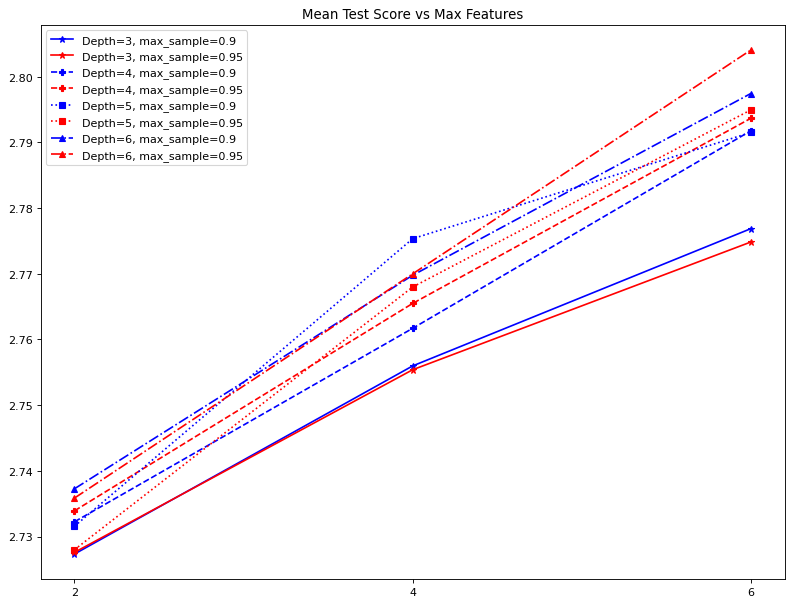

In [342]:
plt.figure(figsize=(12, 9), dpi=80)

plt.plot(depththree_ninety.iloc[:, 0], depththree_ninety.iloc[:, 1], "blue", marker="*")
plt.plot(depththree_ninetyfive.iloc[:, 0], depththree_ninetyfive.iloc[:, 1], "red", marker="*")

plt.plot(depthfour_ninety.iloc[:, 0], depthfour_ninety.iloc[:, 1], "blue", linestyle="dashed", marker="P")
plt.plot(depthfour_ninetyfive.iloc[:, 0], depthfour_ninetyfive.iloc[:, 1], "red", linestyle="dashed", marker="P")

plt.plot(depthfive_ninety.iloc[:, 0], depthfive_ninety.iloc[:, 1], "blue", linestyle="dotted", marker="s")
plt.plot(depthfive_ninetyfive.iloc[:, 0], depthfive_ninetyfive.iloc[:, 1], "red", linestyle="dotted", marker="s")

plt.plot(depthsix_ninety.iloc[:, 0], depthsix_ninety.iloc[:, 1], "blue", linestyle="dashdot", marker="^")
plt.plot(depthsix_ninetyfive.iloc[:, 0], depthsix_ninetyfive.iloc[:, 1], "red", linestyle="dashdot", marker="^")

plt.legend(["Depth=3, max_sample=0.9", "Depth=3, max_sample=0.95",
            "Depth=4, max_sample=0.9", "Depth=4, max_sample=0.95",
            "Depth=5, max_sample=0.9", "Depth=5, max_sample=0.95",
            "Depth=6, max_sample=0.9", "Depth=6, max_sample=0.95"])

plt.xticks([2, 4, 6])
plt.title("Mean Test Score vs Max Features")

Get and save final model.

In [337]:
sev_rf_final = sev_final_grid.best_estimator_

# joblib.dump(sev_rf_final, "../models/sev_rf.pkl")

['../models/sev_rf.pkl']

In [22]:
sev_rf_final = joblib.load("../models/sev_rf.pkl")

## Explaining the model.

### Feature importances

Plotting the feature importances.

<b>Frequency:</b> Looks like the two most important features are *AGEPH* and *SPLIT*, with *usec*, *sportc*, *powerc*, *agecar* and *sexp* taking very little effect. 

The more extreme differences in frequency plots may be explained due to the depth being set at 7. I think, since the we only use two features per split, more depth gives more opportunity for good splits (e.g. *AGEPH*) to occur in a single tree, but on the same time also forces bad splits to happen more often (e.g. *usec* is taken, since the other option *sportc* is even worse). When the bad splits are forced to happen it only reduces the deviance by very little and affects its feature importance score.


<b>Severity:</b> More balanced feature importances due to lower depth. Here the importances are more balanced, with *AGEPH* and the spatial info being the most influential. While we did see that these two features are very important in our previous GLM, I think something else is going on here. *AGEPH* and spatial info are the only continuous features, and this allows for (in theory) infinite splits, putting us back in the situation where high-cardinality categoricals are over-represented in terms of feature importance. 

More interestingly, this continuous over-representation seems to not be as extreme in the frequency plot! Or perhaps the importance of split masks this over-representation. Or even, if you check my *gam_binning* notebook, you will see that the bins for severity has an "almost-vertical" strip starting just west of Maastricht going downwards which is classified as more-severe. This strip is easier for a single tree to capture, so this may partly explain the importance of the spatial features for severity.

In [34]:
freq_importances = pd.DataFrame({"Feature":freq_rf_final.feature_names_in_,
                                 "Importance": freq_rf_final.feature_importances_})

sev_importances = pd.DataFrame({"Feature":sev_rf_final.feature_names_in_,
                                 "Importance": sev_rf_final.feature_importances_})

In [35]:
freq_text = "max_depth=7 \nmax_features=2 \nmax_samples=0.85 \nn_estimators=1000"
sev_text = "max_depth=3 \nmax_features=2 \nmax_samples=0.9 \nn_estimators=1000"

<BarContainer object of 12 artists>

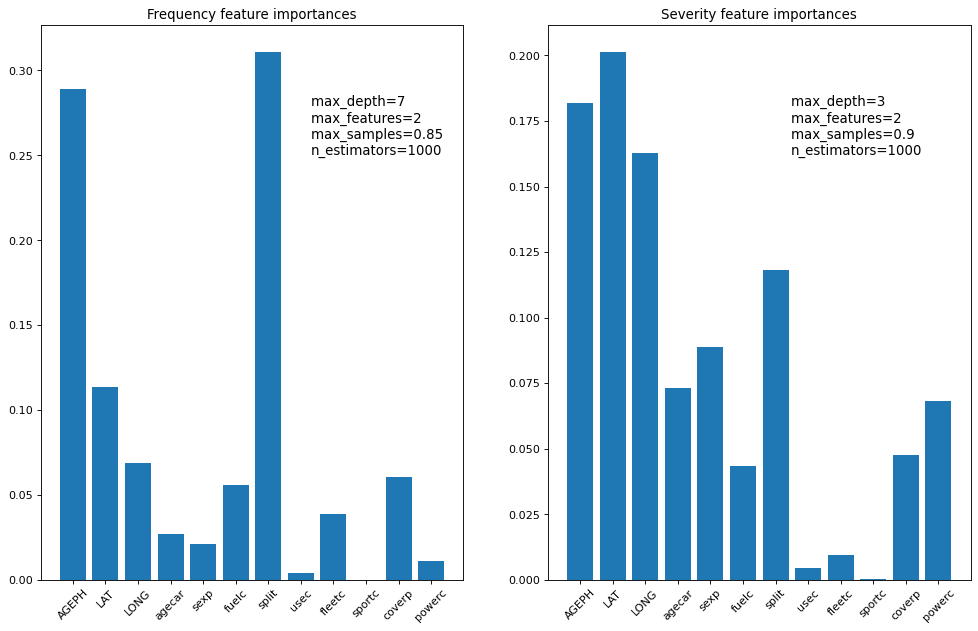

In [36]:
plt.figure(figsize=(15, 9), dpi=80)

plt.subplot(1, 2, 1)
plt.xticks(rotation=45)
plt.title("Frequency feature importances")
plt.figtext(0.35, 0.70, freq_text, fontsize="large")
plt.bar(x=freq_importances["Feature"], height=freq_importances['Importance'])

plt.subplot(1, 2, 2)
plt.xticks(rotation=45)
plt.title("Severity feature importances")
plt.figtext(0.75, 0.70, sev_text, fontsize="large")
plt.bar(x=sev_importances["Feature"], height=sev_importances['Importance'])

### Permutation Importance

Permutation importances is less affected by high-cardinality categoricals as feature importances. Since we have three continuous predictors here, let's see if this "standardize" the importances.

In [37]:
freq_perm_imp = permutation_importance(freq_rf_final, freq_features, freq_target, sample_weight=freq_weights,
                                       scoring='neg_mean_poisson_deviance', n_repeats=5, random_state=0, max_samples=1.0)

sev_perm_imp = permutation_importance(sev_rf_final, sev_features, sev_target, sample_weight=sev_weights,
                                       scoring='neg_mean_gamma_deviance', n_repeats=5, random_state=0, max_samples=1.0)

In [38]:
freq_perm_importances = pd.DataFrame({"Feature":freq_features.columns,
                                      "Permutation Importance": freq_perm_imp.importances_mean})

sev_perm_importances = pd.DataFrame({"Feature":sev_features.columns,
                                     "Permutation Importance": sev_perm_imp.importances_mean})

The standardization effect is definitely present, but for the most part the conclusion of which features are important is the same.

In our Poisson GLM, we dropped *usec*, *sportc* and *powerc*. These three variables also scored very low in terms of feature importance and permutation importance. However in the GLM we kept *agecar* and *sexp*. Perhaps we can also use these PDPs to help our decision on which feature to drop in our GLM?

In our Gamma GLM, we only used *splitc*, *AGEPH*, spatial info, and *fuelc*. I didn't drop *fuelc* because drop-in-deviance and BIC values suggest that I shouldn't do so. However these PDPs definitely suggests a possibility of dropping.

<BarContainer object of 12 artists>

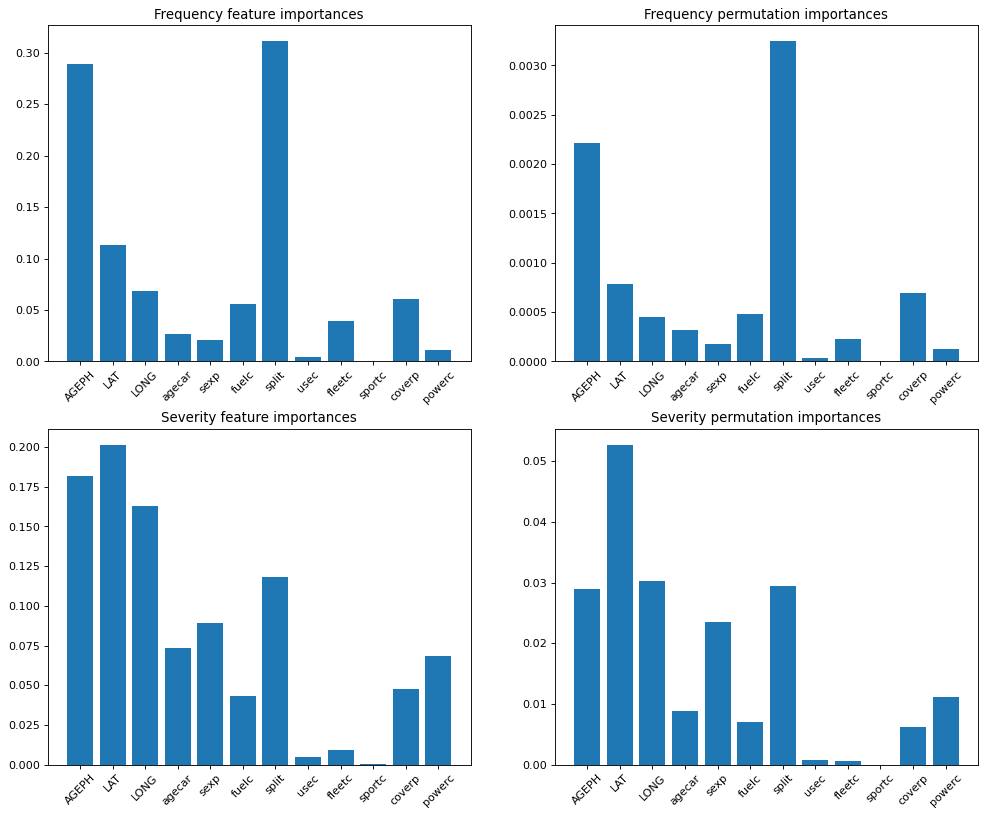

In [39]:
plt.figure(figsize=(15, 12), dpi=80)

plt.subplot(2, 2, 2)
plt.xticks(rotation=45)
plt.title("Frequency permutation importances")
plt.bar(x=freq_perm_importances["Feature"], height=freq_perm_importances['Permutation Importance'])

plt.subplot(2, 2, 1)
plt.xticks(rotation=45)
plt.title("Frequency feature importances")
plt.bar(x=freq_importances["Feature"], height=freq_importances['Importance'])

plt.subplot(2, 2, 4)
plt.xticks(rotation=45)
plt.title("Severity permutation importances")
plt.bar(x=sev_perm_importances["Feature"], height=sev_perm_importances['Permutation Importance'])

plt.subplot(2, 2, 3)
plt.xticks(rotation=45)
plt.title("Severity feature importances")
plt.bar(x=sev_importances["Feature"], height=sev_importances['Importance'])

One can see that latitude becomes very important in severity. Below is an image of the clustered bins based on the GAM. While this information is not used by the random forest, I hope this may shed some light.

<b>I think</b>, we need to consider latitude *in context* of longitude. This is a hypothesis: If we work on the assumption that the longitude are split correctly by the tree (e.g. 4-5 degrees east), then latitude is very significant, one can definitely distinguish the class 5 risk-class between 50-50.5 degrees north from the other milder risk-class regions.

Now if one were to permutate the latitude column, then all of this spatial information is thrown away, and the tree can no longer distinguish the afore-mentioned class 5 risk-class anymore.

There is an order of magnitude in difference between permutation importance values for severity and frequency, however I'm a bit skeptical. I couldn't find an answer immediately, but:
- We used different deviances, Poisson and Gamma.
- Gamma deviance had a scaling factor $\alpha$ that we exchanged in favor of weights $w_i = N_i$.

![Severity postcode bins](../sev_postcode.png)

Here is an excerpt from [SKLearn's Permutation Feature Importance page](https://scikit-learn.org/stable/modules/permutation_importance.html):

> Using a held-out set makes it possible to highlight which features contribute the most to the generalization power of the inspected model. Features that are important on the training set but not on the held-out set might cause the model to overfit.

We still have a validation set and a test set left. Let us use the validation set for now. This contains $16\%$ of the total dataset, about 25600 observations.

Read the validation dataset. The code below is just a copy and paste of previous code to plot the permutation importances.

In [66]:
valid = pd.read_csv("../data/valid.csv", index_col="Unnamed: 0")

valid2 = postcodes_to_latlong(valid)
valid2.head()

,AGEPH,duree,lnexpo,nbrtotc,nbrtotan,chargtot,agecar,sexp,fuelc,split,usec,fleetc,sportc,coverp,powerc,LAT,LONG
0,33,1.0,0.0,0,0.0,0.0,6-10,Male,Petrol,Twice,Private,No,No,MTPL,<66,50.383333,3.766667
1,62,1.0,0.0,0,0.0,0.0,>10,Female,Petrol,Once,Private,No,No,MTPL+,<66,50.450000,4.350000
2,65,1.0,0.0,0,0.0,0.0,6-10,Male,Petrol,Once,Private,No,No,MTPL,<66,51.100000,4.316667
3,72,1.0,0.0,0,0.0,0.0,6-10,Male,Petrol,Once,Private,No,No,MTPL+,<66,51.033333,5.583333
4,23,1.0,0.0,0,0.0,0.0,6-10,Male,Petrol,Thrice,Private,No,Yes,MTPL,66-110,50.566667,4.066667


In [67]:
valid2 = cat_to_numeric(valid2)

for category in categoricals:
    print(category + ":", valid2[category].unique())

agecar: [2 3 1 0]
sexp: [0 1]
fuelc: [0 1]
split: [2 0 3 1]
usec: [0 1]
fleetc: [1 0]
sportc: [1 0]
coverp: [0 1 2]
powerc: [0 1 2]


In [68]:
valid_freq_target = valid2['nbrtotc']/valid2['duree']
valid_freq_weights = valid2['duree']
valid_freq_features = valid2.loc[:, features]

valid_sev_data2 = valid2.query("nbrtotc > 0")

valid_sev_target = valid_sev_data2['chargtot']/valid_sev_data2['nbrtotc']
valid_sev_weights = valid_sev_data2['nbrtotc']
valid_sev_features = valid_sev_data2.loc[:, features]

valid_freq_features.head()

,AGEPH,LAT,LONG,agecar,sexp,fuelc,split,usec,fleetc,sportc,coverp,powerc
0,33,50.383333,3.766667,2,0,0,2,0,1,1,0,0
1,62,50.450000,4.350000,3,1,0,0,0,1,1,1,0
2,65,51.100000,4.316667,2,0,0,0,0,1,1,0,0
3,72,51.033333,5.583333,2,0,0,0,0,1,1,1,0
4,23,50.566667,4.066667,2,0,0,3,0,1,0,0,1


In [69]:
valid_freq_perm_imp = permutation_importance(freq_rf_final, valid_freq_features, valid_freq_target,
                                             sample_weight=valid_freq_weights, scoring='neg_mean_poisson_deviance',
                                             n_repeats=5, random_state=0, max_samples=1.0)

valid_sev_perm_imp = permutation_importance(sev_rf_final, valid_sev_features, valid_sev_target, sample_weight=valid_sev_weights,
                                            scoring='neg_mean_gamma_deviance', n_repeats=5, random_state=0, max_samples=1.0)

valid_freq_perm_importances = pd.DataFrame({"Feature":valid_freq_features.columns,
                                            "Permutation Importance": valid_freq_perm_imp.importances_mean})

valid_sev_perm_importances = pd.DataFrame({"Feature":valid_sev_features.columns,
                                           "Permutation Importance": valid_sev_perm_imp.importances_mean})

For features that are relevant towards the prediction, seems like there aren't too much difference, but the permutation importances on the validation set really highlights which variables are useless (and can be thrown away if we were to create a GLM based on this, for example). For severity, by looking at the validation figure, we really only should keep *AGEPH*, spatial info, *split* and *coverp*. These differ by the co-variates we chose for the Gamma GLM however, we didn't deem *coverp* as important, and instead *fuelc* was used.

<BarContainer object of 12 artists>

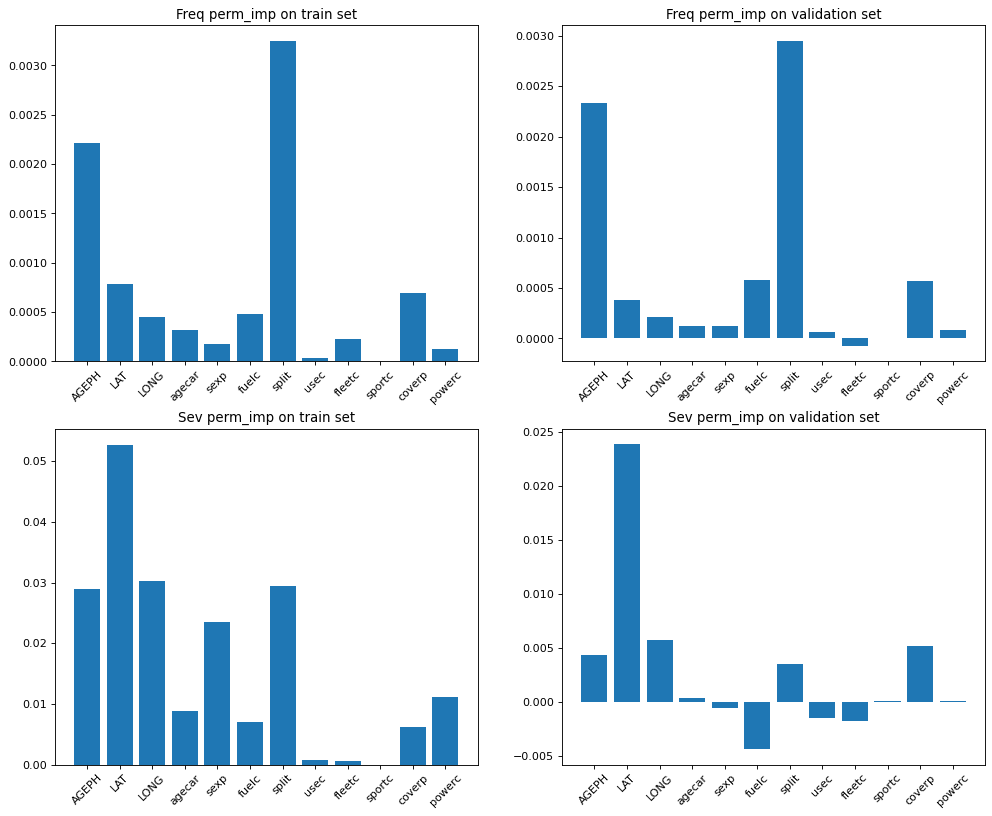

In [72]:
plt.figure(figsize=(15, 12), dpi=80)

plt.subplot(2, 2, 1)
plt.xticks(rotation=45)
plt.title("Freq perm_imp on train set")
plt.bar(x=freq_perm_importances["Feature"], height=freq_perm_importances['Permutation Importance'])

plt.subplot(2, 2, 2)
plt.xticks(rotation=45)
plt.title("Freq perm_imp on validation set")
plt.bar(x=valid_freq_perm_importances["Feature"], height=valid_freq_perm_importances['Permutation Importance'])

plt.subplot(2, 2, 3)
plt.xticks(rotation=45)
plt.title("Sev perm_imp on train set")
plt.bar(x=sev_perm_importances["Feature"], height=sev_perm_importances['Permutation Importance'])

plt.subplot(2, 2, 4)
plt.xticks(rotation=45)
plt.title("Sev perm_imp on validation set")
plt.bar(x=valid_sev_perm_importances["Feature"], height=valid_sev_perm_importances['Permutation Importance'])

### Partial Dependence Plots

Plotting the PDPs. Unfortunately I still have sklearn version 1.0.2, so I can't plot categorical features' PDPs as a barplot automatically. Argument *categorical_features* in *from_estimator()* below is only introduced in 1.2.

#### Frequency PDPs

From these PDPs we can see that we should be able to throw out *sportc* entirely. Features such as *powerc* and *usec* might be thrown out as well since they only have a little effect. These results confirm the feature importance and permutation importance earlier.

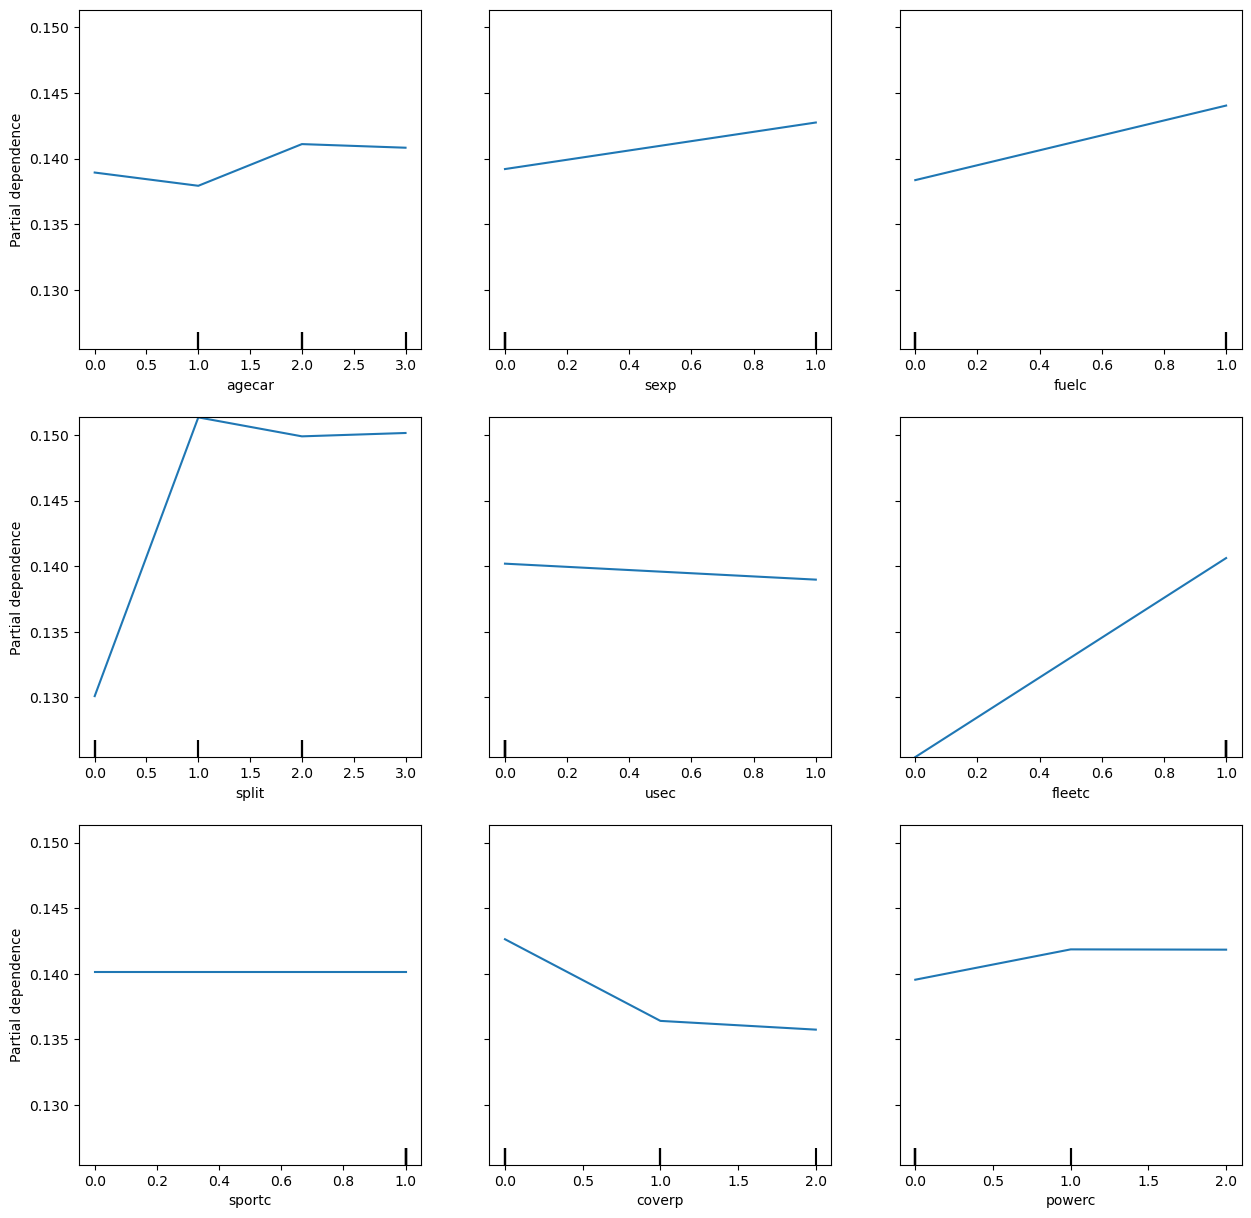

In [463]:
fig, ax = plt.subplots(figsize=(15, 15))
PartialDependenceDisplay.from_estimator(estimator=freq_rf_final, X=freq_features,
                                        features=list(categoricals), 
                                        # categorical_features=list(categoricals),
                                        kind='average', ax=ax);

PDPs for continuous features. The latitude and longitude isn't really that interpretable. Maybe a finer level-set partition for the contour would have done better.

On the other hand, it is interesting that the PDP we get for *AGEPH* does not agree with the smooth function we received from the GAM used for binning the continuous features for our glm. The flat tail (*AGEPH* $\geq 78$) may be due to not having enough data to split further for older policy holders, I set the minimum split node count to be $5\%$, but only 1809 policy holders are older than 78. I can't explain this divergence in other places from the tail.

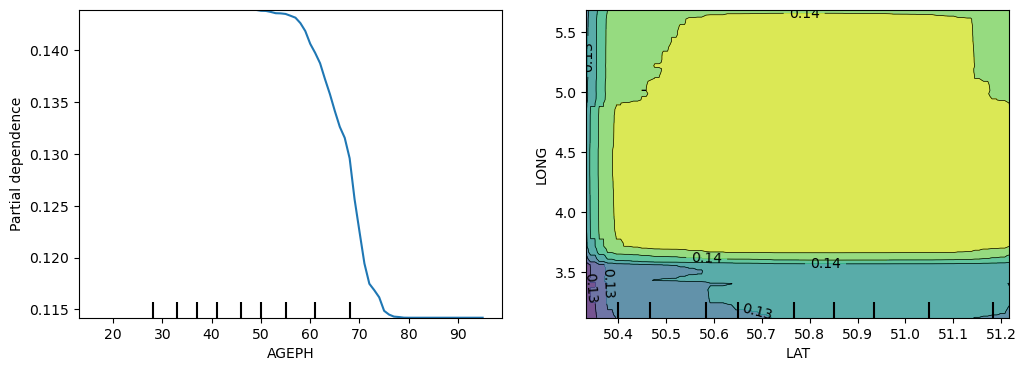

In [499]:
fig, ax = plt.subplots(figsize=(12, 4))
PartialDependenceDisplay.from_estimator(estimator=freq_rf_final, X=freq_features,
                                        features=["AGEPH", ("LAT", "LONG")], 
                                        # categorical_features=list(categoricals),
                                        kind='average', ax=ax);

Smooth functions for the spatial data and *AGEPH* we received from the GAM we used to bin said features.

![FREQ_GAM PDP](../freq_gam_pdp.png)

In [500]:
data.query("AGEPH >= 78").shape

(1809, 16)

#### Severity PDPs

*Sportc* can definitely be dropped.

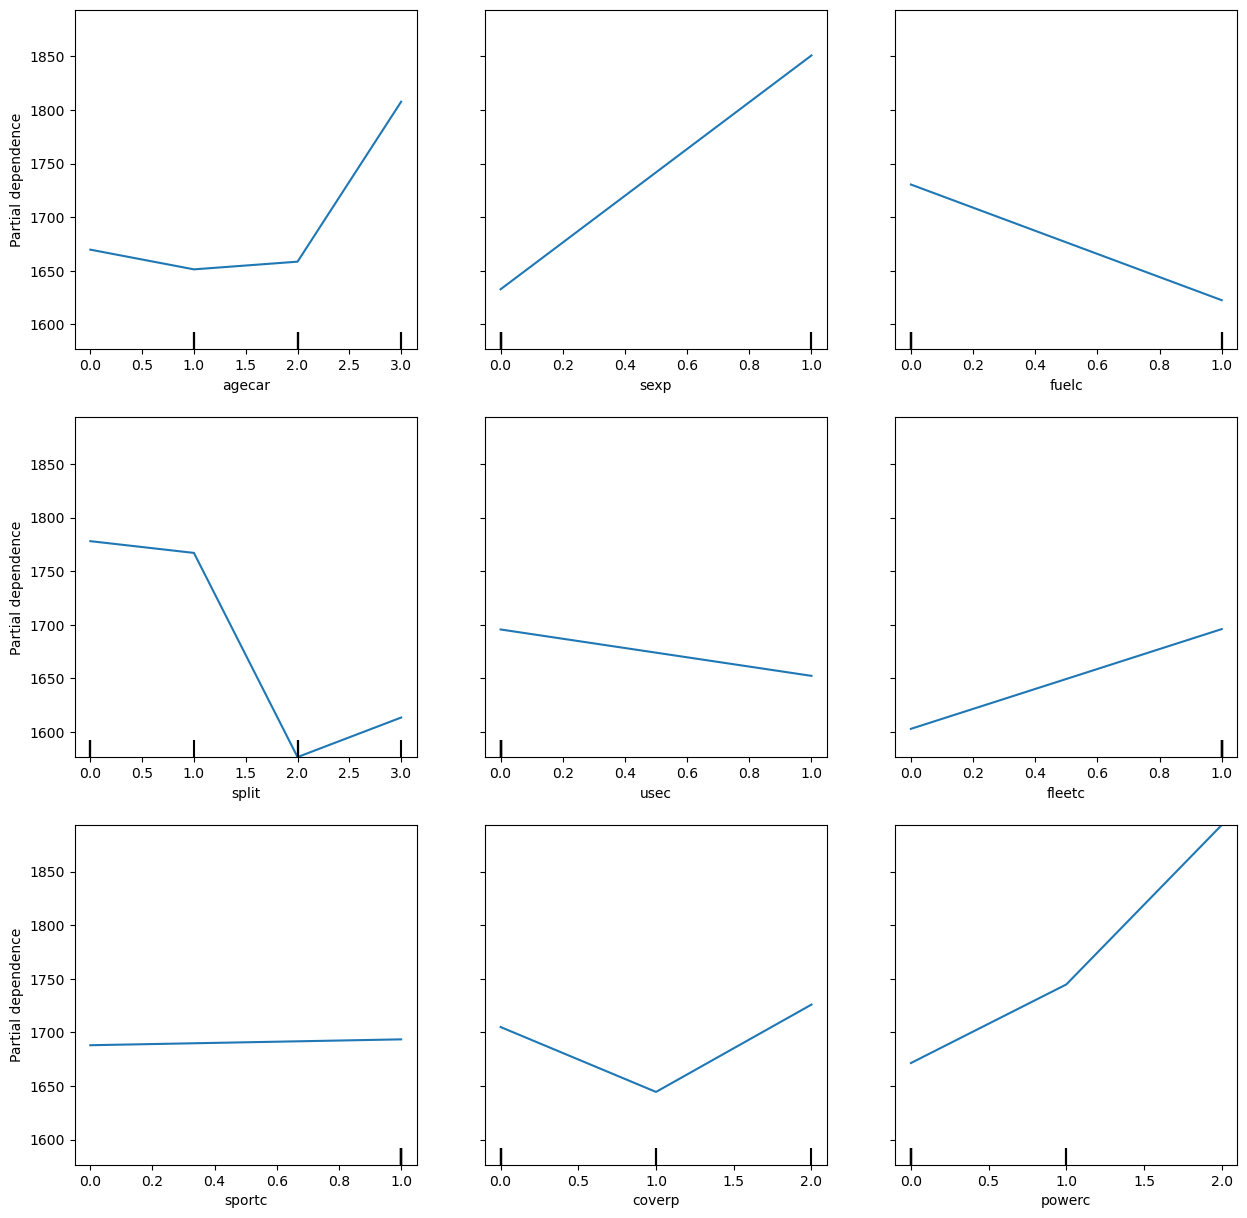

In [502]:
fig, ax = plt.subplots(figsize=(15, 15))
PartialDependenceDisplay.from_estimator(estimator=sev_rf_final, X=sev_features,
                                        features=list(categoricals), 
                                        # categorical_features=list(categoricals),
                                        kind='average', ax=ax);

Once more, a bit hard to interpret the spatial PDP. However, the general shape of the PDP of *AGEPH* and the smooth function for *AGEPH* is different.

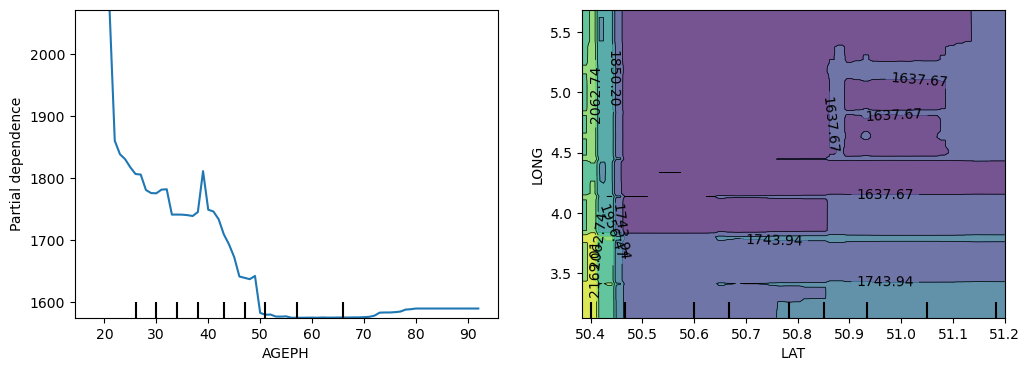

In [504]:
fig, ax = plt.subplots(figsize=(12, 4))
PartialDependenceDisplay.from_estimator(estimator=sev_rf_final, X=sev_features,
                                        features=["AGEPH", ("LAT", "LONG")], 
                                        # categorical_features=list(categoricals),
                                        kind='average', ax=ax);

![SEV_GAM PDP](../sev_gam_pdp.png)

## Analyzing the tariff-plan

Read the test data, and generate the tariff-plans.

In [105]:
test = pd.read_csv("../data/test.csv", index_col="Unnamed: 0")
test2 = postcodes_to_latlong(test)
test = cat_to_numeric(test2)

test.head()

,AGEPH,duree,lnexpo,nbrtotc,nbrtotan,chargtot,agecar,sexp,fuelc,split,usec,fleetc,sportc,coverp,powerc,LAT,LONG
0,55,0.495890,-0.701400,0,0.0,0.000000,1,0,1,0,0,1,1,2,0,50.466667,4.183333
1,46,1.000000,0.000000,1,1.0,145.017712,2,0,0,2,0,1,1,1,0,50.383333,4.683333
2,42,0.509589,-0.674151,0,0.0,0.000000,2,0,0,0,1,1,1,0,0,50.883333,3.433333
3,24,1.000000,0.000000,0,0.0,0.000000,1,0,0,3,0,1,1,0,0,51.216667,2.900000
4,79,1.000000,0.000000,0,0.0,0.000000,3,1,0,3,0,1,1,0,0,50.683333,4.200000


Get the predictions

In [106]:
test_freq_preds = freq_rf_final.predict(test.loc[:, features])
test_sev_preds = sev_rf_final.predict(test.loc[:, features])

Get the actual "target".

In [111]:
test_results = test.loc[:, ["nbrtotc", "chargtot"]]  # to get zeroes first
test_results['avg_claim'] = test_results.apply(lambda row: avg_claim(row), axis=1)

test_results['freq_preds'] = test_freq_preds
test_results['sev_preds'] = test_sev_preds
test_results['tariff_preds'] = test_results['freq_preds']*test_results['sev_preds']

test_results = test_results.iloc[:, [0, 2, 1, 3, 4, 5]]
test_results.query("nbrtotc > 1")[0:6]

,nbrtotc,avg_claim,chargtot,freq_preds,sev_preds,tariff_preds
24,2,883.975915,1767.951829,0.168462,1466.489643,247.047585
29,2,278.582743,557.165486,0.166913,1734.311468,289.479941
69,2,158.676645,317.353290,0.163527,1963.060437,321.012661
126,2,384.495252,768.990503,0.152646,1229.984087,187.751719
154,2,840.842441,1681.684883,0.162941,1665.337240,271.352438
261,2,126.004279,252.008557,0.162606,1569.615446,255.229655


In [115]:
test_results['tariff_preds'].value_counts()

204.889198    5
237.267969    4
276.236044    4
298.364139    4
251.827276    4
             ..
283.629602    1
216.104367    1
236.543582    1
179.270537    1
184.018722    1
Name: tariff_preds, Length: 31778, dtype: int64